# Processing nc14Melav01-01.czi

In [1]:
# Import my packages.
import flymovie as fm
import os
import copy
import scipy
import numpy as np
import matplotlib.pyplot as plt

# Activate package autoload.
%load_ext autoreload
%autoreload 2

In [26]:
%reload_ext autoreload

## 1. Read input files

In [6]:
# Set channels corresponding to nuclear signal and MS2 spots.
nucchannel = 1
spotchannel = 0

surface_before = 2491
surface_after = 2491.1

# Set files for output movie object and input files.
czi_folder = '/Users/michaelstadler/Downloads/'

czi_files = ['nc14Melav01-01.czi'
]

mv_filename = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/Movie_processing/Processing-nc14Melav01-01.pkl'

In [93]:
stack.shape

(2, 48, 21, 256, 1024)

In [94]:
z_interval

0.29

In [92]:
starting_positionsa

[2501.8]

In [44]:
# Read and join czi files into single image stack, recording frames at which movies
# are joined and starting Z positions; view stack.
stack, join_frames, starting_positions, z_interval = fm.read_czi_multiple(czi_files, czi_folder)
fm.viewer(stack, 10, zmax=True)

interactive(children=(Dropdown(description='Color', index=3, options=('magma', 'Reds', 'viridis', 'cividis', '…

## 2. Nuclear Segmentation
### 2-1 Determine parameters for segmentation of nuclei.

In [52]:
# Perform initial nuclear segmentation using the first few frames to determine parameters.
min_nuc_center_dist = 40
sigma = 5
usemax = True

nucmask_test = fm.segment_nuclei_4dstack(stack[1, :1], fm.segment_nuclei.segment_nuclei_3Dstack_rpb1, min_nuc_center_dist=min_nuc_center_dist, sigma=sigma, usemax=usemax, display=False)
fm.viewer(nucmask_test, 10, color='prism')

interactive(children=(Dropdown(description='Color', index=10, options=('magma', 'Reds', 'viridis', 'cividis', …

### 2-2. Perform initial segmentation

In [53]:
# Segment nuclei using parameters determined above.
nucmask_init = fm.segment_nuclei_4dstack(stack[nucchannel], fm.segment_nuclei_3Dstack_rpb1, min_nuc_center_dist=min_nuc_center_dist, sigma=sigma, usemax=usemax)
fm.viewer(nucmask_init, figsize=10, color='prism')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 


interactive(children=(Dropdown(description='Color', index=10, options=('magma', 'Reds', 'viridis', 'cividis', …

### 2-3. Filter nuclear mask for object size.

In [54]:
# Filter segmented nuclei based on their size.
size_min = 0
size_max = 1.1e5

nucmask_sizefiltered = fm.labelmask_filter_objsize_apply4d(nucmask_init, size_min, size_max)
fm.viewer(nucmask_sizefiltered, figsize=10, color="viridis", init_maxval=1)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 

interactive(children=(Dropdown(description='Color', index=2, options=('magma', 'Reds', 'viridis', 'cividis', '…

### 2-4 (optional) Filter nuclei based on circularity

In [51]:
# Filter segmented nuclei based on circularity (0-1).
slicenum = 6 # Z slice to use for circularity -- irrelevant if using max projections.
circularity_min = 0.5

nucmask_filtercirc = fm.filter_labelmask_circularity_apply4d(nucmask_sizefiltered, slicenum=slicenum, 
    circularity_min=circularity_min)

fm.viewer(nucmask_filtercirc, color="viridis", init_maxval=1)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 

interactive(children=(Dropdown(description='Color', index=2, options=('magma', 'Reds', 'viridis', 'cividis', '…

### Select nuclear mask to use

In [55]:
nucmask_to_connect = nucmask_sizefiltered
#nucmask_to_connect = nucmask_filtercirc

### 2-5 Connect nuclei between frames

In [57]:
max_frames_skipped = 2

nucmask_conn = fm.connect_nuclei(nucmask_to_connect, max_frames_skipped=max_frames_skipped, usemax=True)
fm.viewer(nucmask_conn, 10, color='prism')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 

interactive(children=(Dropdown(description='Color', index=10, options=('magma', 'Reds', 'viridis', 'cividis', …

### 2-6 Interpolate to fill in gaps (optional)

In [58]:
#nucmask = fm.interpolate_nuclear_mask(nucmask_conn, 3, usemax=True)
nucmask = nucmask_conn

#### View final mask

In [ ]:
fm.viewer(nucmask, color="viridis", init_maxval=1)

#### Clean up intermediate objects

In [59]:
del nucmask_init, nucmask_sizefiltered, 
try: 
    del nucmask_filtercirc
except:
    pass

## 3. Detecting MS2 spots
### 3-1 Perform gaussian fitting on MS2 channel

In [61]:
#min_distances = (stack.shape[-2], 20, 20)
fitwindow_rad_xy = 10
fitwindow_rad_z = 2
sigma_small = 1

fits = fm.fit_ms2(stack[spotchannel], fitwindow_rad_xy=fitwindow_rad_xy, sigma_small=sigma_small, mode='nucleus', nucmask=nucmask)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 

In [2]:
mv = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/Movie_processing/Processing-nc14Melav01-01.pkl')

In [3]:
nucmask = mv.nucmask
fits = mv.fits
stack = mv.stack

#### View fits

In [4]:
fm.quickview_ms2(stack, fits, 0, figsize=10)

interactive(children=(Dropdown(description='Color', index=10, options=('magma', 'gray', 'Greens', 'viridis', '…

### 3-2 Filter fits

In [7]:
# Parameters for filtering fit
peakiness = 4.0
fits_filtered = fm.filter_ms2fits(fits, peakiness, stack, spotchannel)
fm.quickview_ms2(stack, fits_filtered, 0)

interactive(children=(Dropdown(description='Color', index=10, options=('magma', 'gray', 'Greens', 'viridis', '…

### 3-3 Connect spots between frames

In [8]:
spots_connected = fm.connect_ms2_frames_via_nuclei(fits_filtered, nucmask, nucmask_dilation=7)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 

### 3-4 Filter detected spots on trajectory length

In [9]:
min_len = 1
spot_data_init = fm.filter_spot_duration(spots_connected, min_len)

### 3-5 Review spot calling

#### Record bad spot calls and missing spot calls

In [10]:
fm.quickview_ms2(stack, spot_data_init, channel = spotchannel, MAX=True, grid=False)

interactive(children=(Dropdown(description='Color', index=10, options=('magma', 'gray', 'Greens', 'viridis', '…

In [11]:
missing_spots = (
    # spot_id, frame_number
    (28,0),
    (6,1),
    (27,2),
    (27,3),
    (3,6),
    (21,8),
    (21,9),
    (23,8),
    (6,16),
    (13,19),
    (27,19),
    (17,21),
    (42,22),
    (26,22),
    (27,28),
    (27,30)
)

bad_spots = []


### 3-6 Manually enter coordinates for missing spots

In [12]:
new_spots = []
fm.add_missing_spots(spot_data_init, stack, missing_spots, new_spots, channel=spotchannel)

interactive(children=(BoundedIntText(value=0, description='missing_spot', max=15), IntText(value=0, descriptio…

### 3-7 Apply manual corrections

In [14]:
fitwindow_rad_z = 2
fitwindow_rad_xy = 5
spot_data = fm.spot_data_apply_manual_curations(spot_data_init, new_spots, bad_spots, 
    stack, fitwindow_rad_xy=fitwindow_rad_xy, fitwindow_rad_z=fitwindow_rad_z, channel=spotchannel)

#### View final spot detections

In [15]:
fm.quickview_ms2(stack, spot_data, channel=spotchannel)

interactive(children=(Dropdown(description='Color', index=10, options=('magma', 'gray', 'Greens', 'viridis', '…

## 4. Integrate signal around spots, apply corrections.


In [16]:
paramgrids = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210616-depth-correction-params.pkl')

In [17]:
mv = fm.movie(stack, nucmask, fits, spot_data)
fm.analyze.mv_process_apply_corrections(mv, paramgrids, surface_before, surface_after, join_frames, starting_positions, z_interval, ij_rad=7, z_rad=2, fit_depth_min=11, fit_depth_max=14)


NameError: name 'join_frames' is not defined

## 5. QC

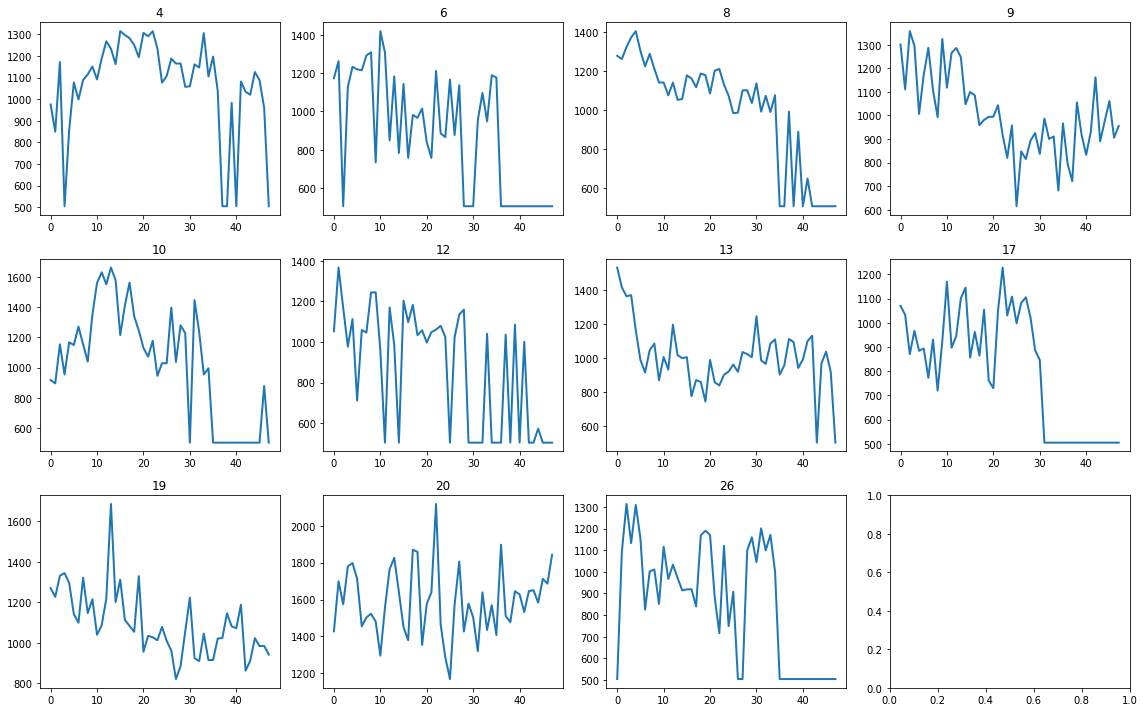

In [113]:
# Plot some traces to see if they look reasonable.
fm.spotdf_plot_traces([mv.ms2_bleachcorr], minlen=30, sigma=0.05, norm=False, figsize=(16,10))

/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin/flymovie/detect_spots.py:926: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2)


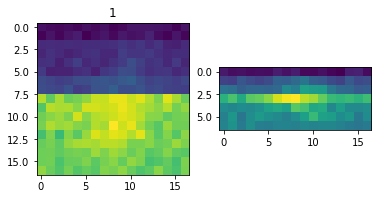

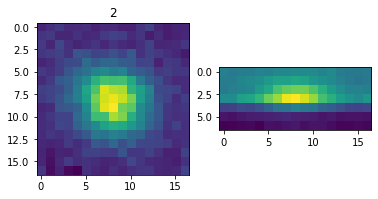

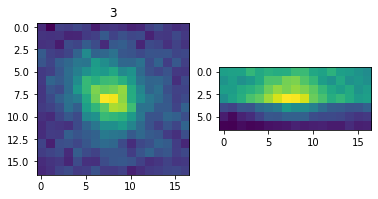

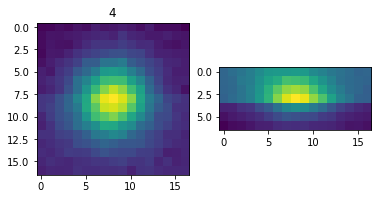

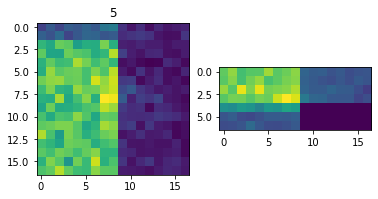

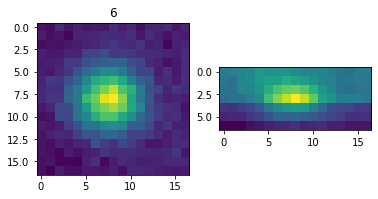

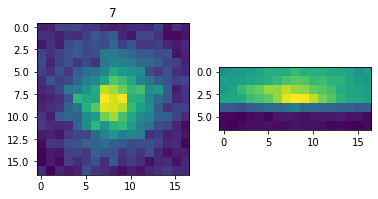

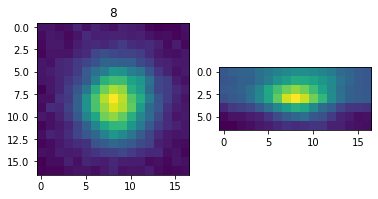

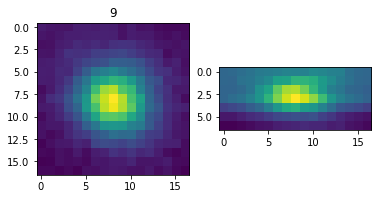

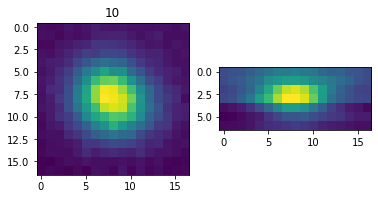

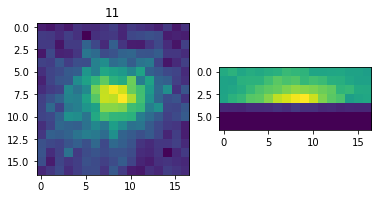

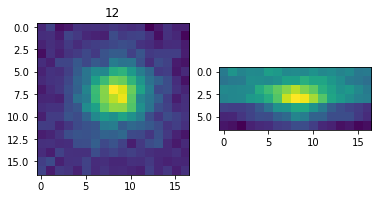

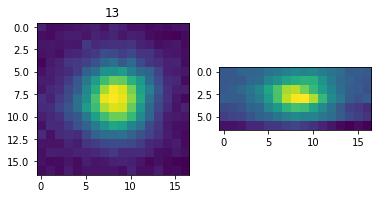

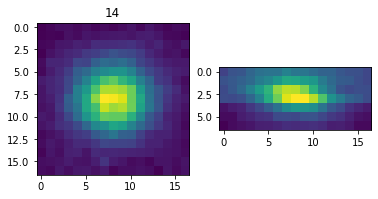

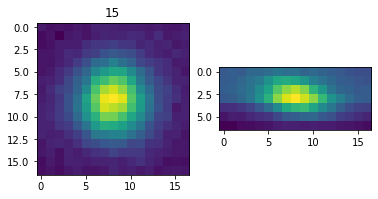

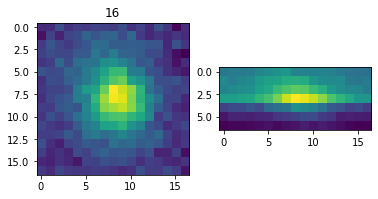

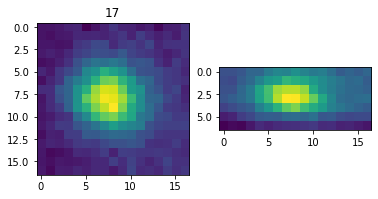

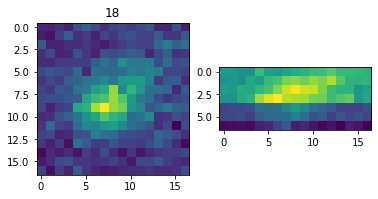

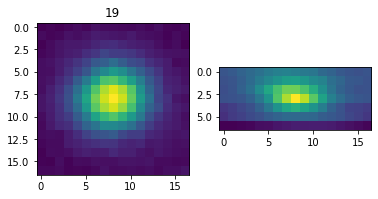

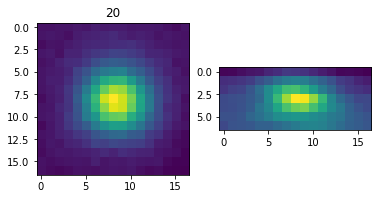

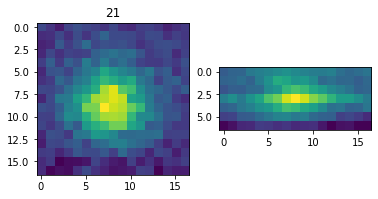

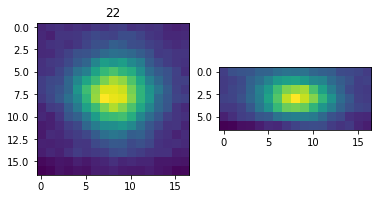

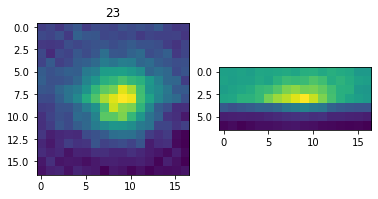

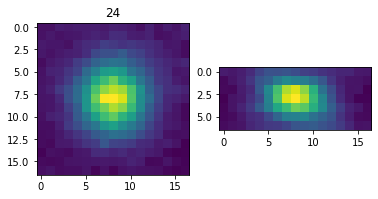

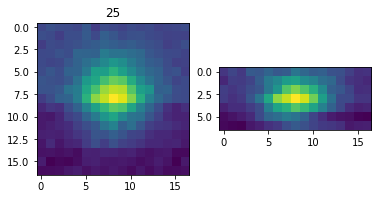

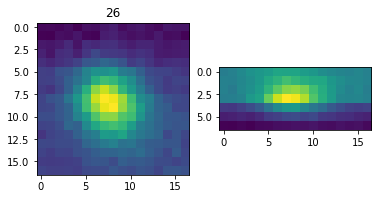

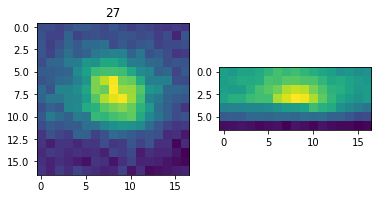

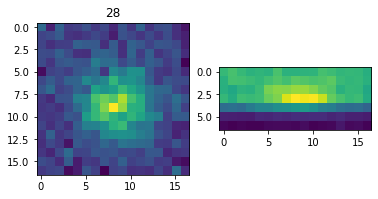

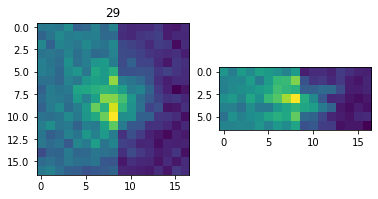

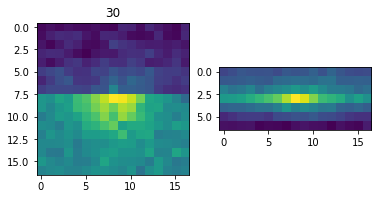

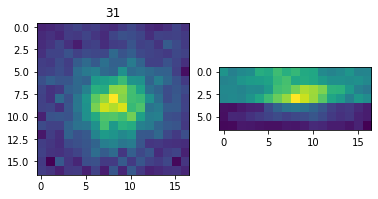

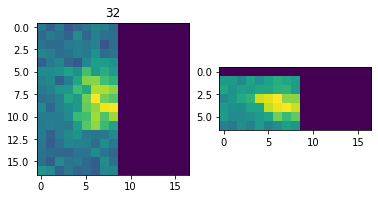

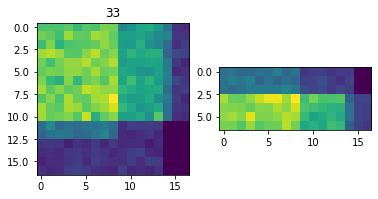

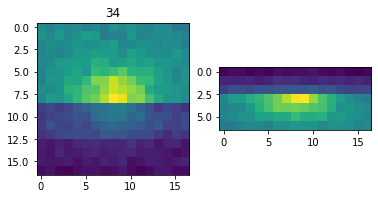

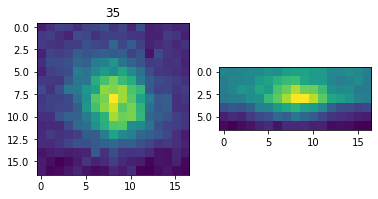

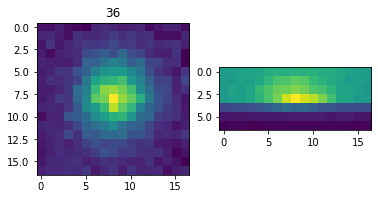

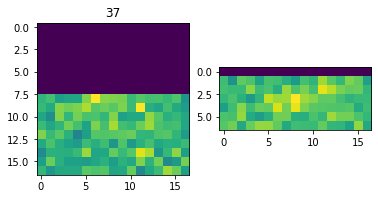

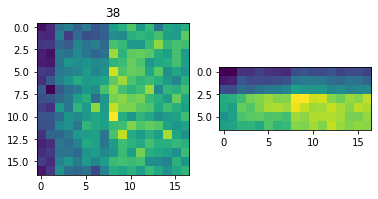

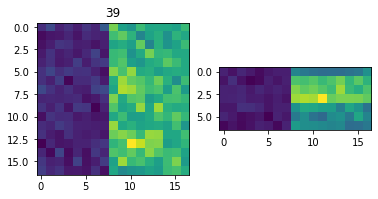

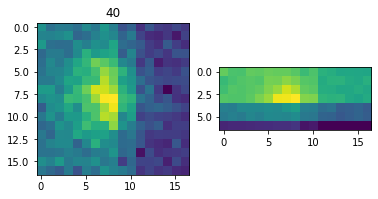

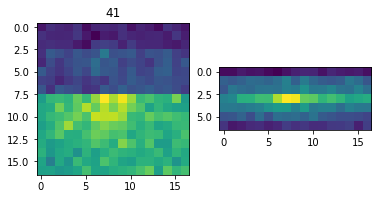

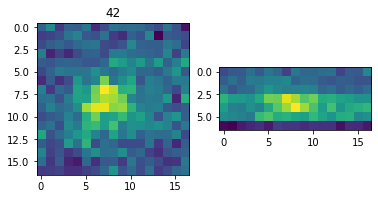

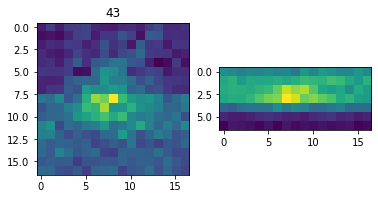

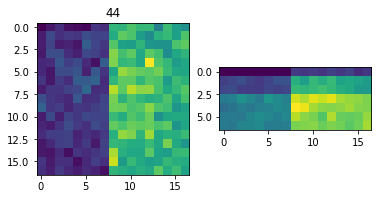

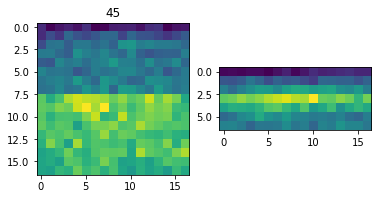

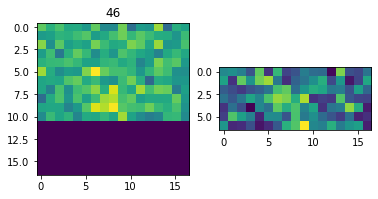

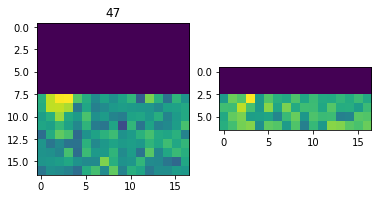

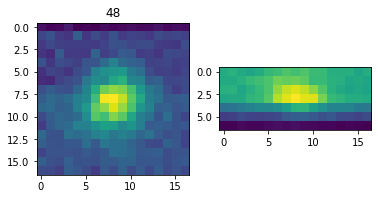

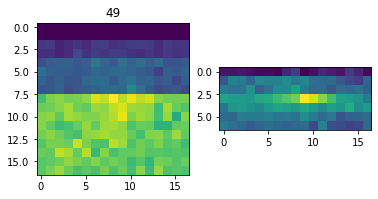

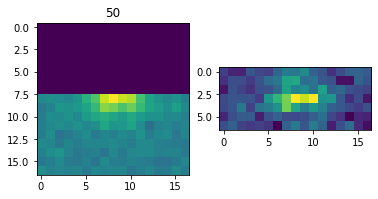

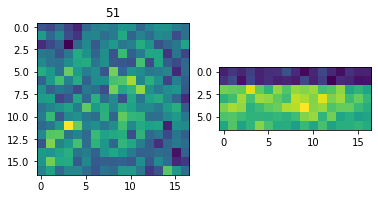

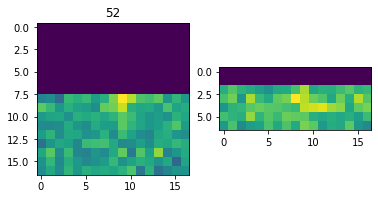

In [108]:
fm.plot_projections(mv, channel=spotchannel)


In [111]:
# View "spot movies", small boxes of stack data centered on detected spots.
spot_movies = fm.spot_movies(mv.stack, mv.spot_data, channel=spotchannel, len_ij=51, fill=0)
# Mean projection of z slices -1 to +1:
#fm.viewer(spot_movies[:,:,2:5].mean(axis=2), 5, order='ntxy', color='cividis')
# No projection (with Z axis):
fm.viewer(spot_movies, 5, order='ntzxy', color='cividis')

interactive(children=(Dropdown(description='Color', index=3, options=('magma', 'Reds', 'viridis', 'cividis', '…

In [ ]:
# Optional: Examine individual spots in original data.
spot_to_view = 42
fm.quickview_ms2(mv.stack, mv.spot_data, channel=1, spot_id=spot_to_view, MAX=True, halfwidth_z=1)

### 6. Save movie

In [115]:
fm.save_pickle(mv, mv_filename)